In [5]:
import os, sys

In [6]:
import os, sys
# add to path
sys.path.append("../..")

import attr
import datetime

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

import pandas as pd


In [7]:
import quandl

In [16]:
from filterflow.smc import SMC
from filterflow.base import State, StateSeries, DTYPE_TO_OBSERVATION_SERIES, DTYPE_TO_STATE_SERIES

from filterflow.observation.base import ObservationModelBase, ObservationSampler

from filterflow.transition.random_walk import RandomWalkModel
from filterflow.proposal import BootstrapProposalModel
from filterflow.proposal.auxiliary_proposal import AuxiliaryProposal

from filterflow.resampling.criterion import NeffCriterion, AlwaysResample, NeverResample
from filterflow.resampling.standard import SystematicResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform
from filterflow.resampling.differentiable.ricatti.solver import RicattiSolver

from filterflow.resampling.base import NoResampling

from filterflow.state_space_model import StateSpaceModel

## Process data

In [5]:
quandl.ApiConfig.api_key = os.environ['QUANDL_KEY']

In [6]:
#d =  quandl.get("NASDAQOMX/OMXS30", start_date="2012-01-02", end_date="2014-01-02")

#y = np.log(d['Index Value']).diff()[1:] * 100

#y.plot()

References:
- [Towards Smooth Particle Filters for
Likelihood Estimation with
Multivariate Latent Variables
](https://www.cs.ubc.ca/grads/resources/thesis/Nov08/Lee_Anthony.pdf)

Basic Model

$y_t \sim \mathcal{N}(\mathbf{B}\mathbf{f}_t, \mathbf{\Psi})$

$\mathbf{f}_t \sim \mathcal{N}(\mathbf{0}, \mathbf{H}_t)$

$\mathbf{\alpha}_t \sim \mathcal{N}(\mathbf{\Phi}\mathbf{\alpha}_{t-1}, \mathbf{U})$

$\mathbf{\Psi} = \text{diag}(\psi_1, \ldots, \psi_M)$

$\mathbf{H}_t = \text{diag}(\exp(\mathbf{\alpha}_t))$

$\mathbf{\Phi} = \text{diag}(\phi_1, \ldots, \phi_M)$

For identifiability let:

$\mathbf{B} = \begin{bmatrix}
                     1   & 0   & 0   \\
                     0.5 & 1   & 0   \\
                     0.5 & 0.5 & 1   \\
                     0.2 & 0.6 & 0.3 \\
                     0.8 & 0.7 & 0.5
                \end{bmatrix}
$
$\hspace{2cm}$ 
$\mathbf{U} = \begin{bmatrix}
                    0.5 & 0.2 & 0.1 \\
                    0.2 & 0.5 & 0.2 \\
                    0.1 & 0.2 & 0.5
\end{bmatrix}$

In [13]:
K = 3
M = 5
T = 100

In [23]:
# Variables to train
B_init = np.array([[1., 0., 0,], 
                  [0.5, 1., 0.],
                  [0.5, 0.5, 1.],
                  [0.2, 0.6, 0.3],
                  [0.8, 0.7, 0.5]])

U_init = np.array([[0.5, 0.2, 0.1], 
                  [0.2, 0.5, 0.2],
                  [0.1, 0.2, 0.5]])

phi_init = np.repeat(0.9, K)
psi_init = np.repeat(0.5, M)

In [24]:
B = tf.constant(B_init, dtype=float)
U = tf.constant(U_init, dtype=float)
phi = tf.constant(phi_init, dtype=float)
psi = tf.constant(psi_init, dtype=float)

## Transition

In [25]:
zeros = tf.zeros(K, dtype=float)
chol_transition_cov = tf.linalg.cholesky(U)
transition_noise = tfp.distributions.MultivariateNormalTriL(zeros, chol_transition_cov)
transition_matrix = phi
transition_model = RandomWalkModel(transition_matrix, transition_noise)

In [43]:
particles = tf.stack([[tf.constant(np.arange(5)) for _ in range(10)] for _ in range(3)])

In [44]:
particles.shape

TensorShape([3, 10, 5])

In [45]:
tf.linalg.diag(particles)

<tf.Tensor: shape=(3, 10, 5, 5), dtype=int32, numpy=
array([[[[0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0],
         [0, 0, 2, 0, 0],
         [0, 0, 0, 3, 0],
         [0, 0, 0, 0, 4]],

        [[0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0],
         [0, 0, 2, 0, 0],
         [0, 0, 0, 3, 0],
         [0, 0, 0, 0, 4]],

        [[0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0],
         [0, 0, 2, 0, 0],
         [0, 0, 0, 3, 0],
         [0, 0, 0, 0, 4]],

        [[0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0],
         [0, 0, 2, 0, 0],
         [0, 0, 0, 3, 0],
         [0, 0, 0, 0, 4]],

        [[0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0],
         [0, 0, 2, 0, 0],
         [0, 0, 0, 3, 0],
         [0, 0, 0, 0, 4]],

        [[0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0],
         [0, 0, 2, 0, 0],
         [0, 0, 0, 3, 0],
         [0, 0, 0, 0, 4]],

        [[0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0],
         [0, 0, 2, 0, 0],
         [0, 0, 0, 3, 0],
         [0, 0, 0, 0, 4]],

        [[0, 0, 0, 0, 0

In [38]:
tf.map(tf.diag, particles)

AttributeError: module 'tensorflow' has no attribute 'map'

## Observation Model

In [10]:
class SVObservationModel(LinearObservationSampler):
    
    def __init__(self, observation_matrix: tf.Tensor, error_rv: tfp.distributions.Distribution,
                 name="SVObservationModel"):
        super(LinearObservationSampler, self).__init__(observation_matrix=observation_matrix,
                                                       error_rv=error_rv,
                                                       name=name)

    def loglikelihood(self, state: State, observation: tf.Tensor):
        """Computes the loglikelihood of an observation given proposed particles
        :param state: State
            Proposed (predicted) state of the filter given State at t-1 and Observation
        :param observation: ObservationBase
            User/Process given observation
        :return: a tensor of loglikelihoods for all particles
        :rtype: tf.Tensor
        """
        log_vol = state.particles
        vol = tf.linalg.diag(tf.exp(log_vol/2))
        vol_chol = tf.linalg.cholesky(vol)
        f_dist = tfp.distributions.MultivariateNormalTriL(0., vol_chol)
        
        f = f_dist.sample()
        phi_chol = tf.linalg.cholesky(phi)
        obs_dist = tfp.distributions.MultivariateNormalTriL(B @ f, phi_chol)
        observation = obs_dist.sample()
        
        
        log_prob = dist.log_prob(observation)
        return tf.reshape(log_prob, [batch_size, n_particles])

    def sample(self, state: State):
        """Samples a new observation conditionally on latent state
        :param state: State
            State of the filter at t
        :return: observartion 
        :rtype: Observation
        """
        log_vol = state.particles
        vol = tf.linalg.diag(tf.exp(log_vol/2))
        vol_chol = tf.linalg.cholesky(vol)
        f_dist = tfp.distributions.MultivariateNormalTriL(0., vol_chol)
        
        f = f_dist.sample()
        phi_chol = tf.linalg.cholesky(phi)
        obs_dist = tfp.distributions.MultivariateNormalTriL(B @ f, phi_chol)
        observation = obs_dist.sample()
        
        return observation
        

In [ ]:
class LinearObservationSampler(LinearObservationModel, ObservationSampler):

    def __init__(self, observation_matrix: tf.Tensor, error_rv: tfp.distributions.Distribution,
                 name="LinearObservationSampler"):
        super(LinearObservationSampler, self).__init__(observation_matrix=observation_matrix,
                                                       error_rv=error_rv,
                                                       name=name)

    def sample(self, state: State, inputs: tf.Tensor = tf.constant(0.)):
        """Samples a new proposed state conditionally on prior state and some inputs
        :param state: State
            State of the filter at t-1
        :param inputs: tf.Tensor
            Input for transition model
        :return: sampled Observation
        :rtype: Observation
        """
        pushed_particles = tf.linalg.matvec(self._observation_matrix, state.particles)
        observation = pushed_particles + self._error_rv.sample([state.batch_size, state.n_particles])
        return observation

In [11]:
observation_model = SVObservationModel()

## State Space Model

In [12]:
initial_value = tfp.distributions.Normal(0., 1.).sample()* tf.sqrt(sig**2 / (1-phi**2))
ss_model = StateSpaceModel(observation_model=observation_model, transition_model=transition_model)
states, observations = ss_model(initial_value, T)

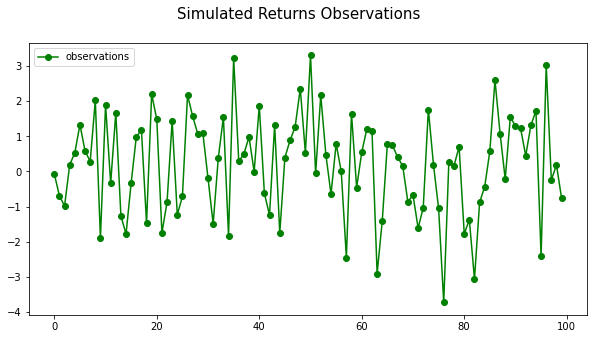

In [13]:
np_obs = np.array([observations[t].numpy().squeeze() for t in range(T)])
np_states = np.array([states[t].particles.numpy().squeeze() for t in range(T)])

linspace  = np.arange(T)
fig, axes = plt.subplots(nrows=1, figsize=(10, 5))
axes.plot(linspace, np_obs, marker='o', color='g', label='observations')
#axes.plot(np_states[:, 1], color='b', label='$h_t$')
_ = axes.legend(loc='upper left')
_ = fig.suptitle('Simulated Returns Observations', fontsize=15)

In [14]:
obs_data = tf.data.Dataset.from_tensor_slices(observations)

## Particle Filter

In [15]:
# store observations
batch_size = 1
n_particles = 100
dimension = 1

In [16]:
# initial state
normal_dist = tfp.distributions.Normal(0., 1.)
initial_particles = normal_dist.sample( [batch_size, n_particles, state_dim])* tf.sqrt(sig**2 / (1-phi**2))

initial_particles = tf.cast(initial_particles, dtype=float)

initial_weights = tf.ones((batch_size, n_particles), dtype=float) / tf.cast(n_particles, float)
log_likelihoods = tf.zeros(batch_size, dtype=float)
initial_state = State(particles=initial_particles, 
                      log_weights = tf.math.log(initial_weights),
                      weights=initial_weights, 
                      log_likelihoods=log_likelihoods)

In [17]:
# proposal
proposal_model = BootstrapProposalModel(transition_model)

# resampling
resampling_criterion = NeffCriterion(tf.constant(0.5), tf.constant(True))
systematic = SystematicResampler()
multinomial = MultinomialResampler()


epsilon = tf.constant(0.25)
scaling = tf.constant(0.9)

regularized = RegularisedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4)
solver = RicattiSolver(0.2, 10., 1e-3)
corrected = CorrectedRegularizedTransform(epsilon, scaling=scaling, max_iter=1000, convergence_threshold=1e-4, ricatti_solver=solver, propagate_correction_gradient=False)


In [18]:
particle_filter = SMC(observation_model, transition_model, proposal_model, resampling_criterion, systematic)

In [19]:
recorded_states = particle_filter(initial_state, observation_series=obs_data, n_observations=T)

In [20]:
recorded_states  = attr.evolve(recorded_states)

In [21]:
# compute states
computed_states = []
for t, observation in enumerate(observations):
    state = recorded_states.read(tf.constant(t, dtype=tf.int32))
    log_weights = state.log_weights.numpy()
    particles = state.particles.numpy()[:,:,0]
    weights = np.exp(log_weights)
    computed_state = np.sum((weights * particles), axis=1)
    computed_states.append(computed_state)
    
computed_states = np.array(computed_states).flatten()

In [22]:
ht = np.array([state.particles.numpy() for state in states]).squeeze()

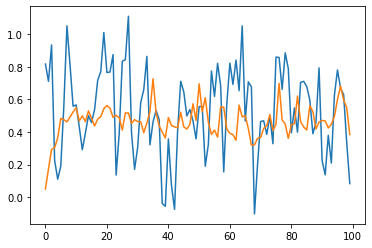

In [23]:
plt.plot(ht)
plt.plot(computed_states)